In [2]:
import torch 
import os
import numpy as np
import scipy as sp
import scipy.io as sio
import python_utils
# import utils
from torch import nn
from torch.nn import functional as F
from torch import optim
from net.chemtools.PLS import PLS
from net.base_net import CuiNet,DeepSpectraCNN,ResNet18_1D,ViT_1D,FullyConvNet
from utils.testing import test                      # ligne rajoutée
from utils.testing import ccc,r2_score,RMSEP
import matplotlib.pyplot as plt
from utils.training import train
from utils.testing import test 
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split

# JC pour importer les fichiers tabulés
import numpy as np
import pandas as pd
import sys 


2025-01-15 14:55:23.886617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# un lien relatif permet de placer le répertoire Deep-chemometrics-jcb n'importe où sur le disque
local_path=os.getcwd()

# la première ligne commentée est celle valable pour galaxy

#X_train=pd.read_csv("${Xdata.file_name}", sep="\t", header=0)
local_path_xcal=local_path+'/data/rmn_196/xtrain_rmn.tab'
Xcal=pd.read_csv(local_path_xcal, sep="\t", header=0)
Xcal.drop(Xcal.columns[0],axis=1,inplace=True)

#Y_train=pd.read_csv("${Ydata.file_name}", sep="\t", header=0)
local_path_ycal=local_path+'/data/rmn_196/ytrain_rmn.tab'
Ycal=pd.read_csv(local_path_ycal, sep="\t", header=0)

#X_test =pd.read_csv("${Xdata_val.file_name}", sep="\t", header=0)
local_path_xtest=local_path+'/data/rmn_196/xtest_rmn.tab'
Xtest=pd.read_csv(local_path_xtest, sep="\t", header=0)
Xtest.drop(Xtest.columns[0],axis=1,inplace=True)

#Y_test =pd.read_csv("${Xdata_val.file_name}", sep="\t", header=0)
local_path_ytest=local_path+'/data/rmn_196/ytest_rmn.tab'
Ytest=pd.read_csv(local_path_ytest, sep="\t", header=0)

## partie à décommenter pour galaxy
#Y_column=${Ycolumn}-1
#Y_column_val=${Ycolumn_val}-1   ## debut a 0

Ycal=Ycal.iloc[:,1:2]
Ytest=Ytest.iloc[:,1:2]

In [4]:
print("X and Y training set")
print(Ycal.shape)
print(Xcal.shape)

X and Y training set
(147, 1)
(147, 2101)


In [4]:
print("X and Y testing set")
print(Ytest.shape)
print(Xtest.shape)

X and Y testing set
(49, 1)
(49, 2101)


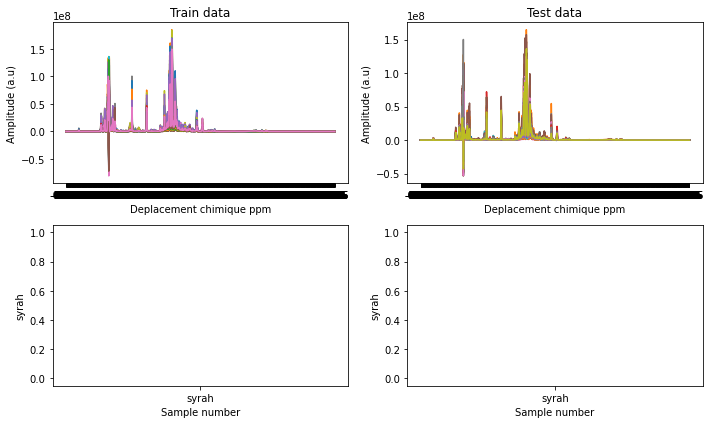

In [5]:
plt.figure(figsize=(10,6))

plt.subplot(221)
plt.title('Train data')
plt.plot(Xcal.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Deplacement chimique ppm')

plt.subplot(222)
plt.title('Test data')
plt.plot(Xtest.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Deplacement chimique ppm')

plt.subplot(223)
# plt.plot(data['DM_cal'])
plt.plot(Ycal.T)
plt.ylabel('syrah')
plt.xlabel('Sample number')

plt.subplot(224)
# plt.plot(data['DM_test'])
plt.plot(Ytest.T)
plt.ylabel('syrah')
plt.xlabel('Sample number')

plt.tight_layout()
plt.show()

In [9]:
## Spliting the train set 
x_cal, x_val, y_cal, y_val = train_test_split(Xcal, Ycal, test_size=0.20, shuffle=True, random_state=42) 

## The wavelenghts for the XX axis when we plot the spectra
# x_scale=data['wave'].astype(np.float32).reshape(-1,1)               data ne sert pas car fichier pas matlab

## Check for dimensions
print('Data set dimensions ----------------------------')
print('Full Train set dims X Y = {}\t{}'.format(Xcal.shape, Ycal.shape))
print('Calibration set dims X Y = {}\t{}'.format(x_cal.shape, y_cal.shape))
print('val set dims X Y = {}\t{}'.format(x_val.shape, y_val.shape))
print('Test set dims X Y = {}\t{}'.format(Xtest.shape, Ytest.shape))
# print('wavelengths number = {}'.format(np.shape(x_scale)))          pas data -> pas xscale

Data set dimensions ----------------------------
Full Train set dims X Y = (147, 2101)	(147, 1)
Calibration set dims X Y = (117, 2101)	(117, 1)
val set dims X Y = (30, 2101)	(30, 1)
Test set dims X Y = (49, 2101)	(49, 1)


In [ ]:
## Visual data sanity checking for the test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
# plt.plot(x_val[:50,:].T,'k')
plt.plot(x_val.T,'k')           # .T est la transposée

plt.title('First 50 spectra from the val sample')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Spectra intensity')
plt.subplot(1,2,2)
plt.title('Y labels')
plt.plot(y_val,'k.')
plt.xlabel('Sample number')
plt.ylabel('syrah')
plt.show()

In [8]:
# calculate mean and std per column

mean = np.mean(x_cal, axis=0)
std = np.std(x_cal, axis=0)

# Convert np.array to Dataloader 

# JC conversion en np.array
x_cal=np.array(x_cal)
y_cal=np.array(y_cal)
x_val=np.array(x_val)
y_val=np.array(y_val)
Xtest=np.array(Xtest)
Ytest=np.array(Ytest)

cal = data_utils.TensorDataset(torch.Tensor(x_cal), torch.Tensor(y_cal))
cal_loader = data_utils.DataLoader(cal, batch_size=1024, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
val_loader = data_utils.DataLoader(val, batch_size=1024, shuffle=True)

test_dt = data_utils.TensorDataset(torch.Tensor(Xtest), torch.Tensor(Ytest))
test_loader = data_utils.DataLoader(test_dt, batch_size=1024, shuffle=True)


/Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometrics-jcb/data/rmn_196//models/_cuinet_rmn_14jan25_v1/_cuinet_rmn_14jan25_v1
CuiNet(
  (dropout): ManualDropout()
  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=2097, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=1, bias=True)
)
Epoch 1/100 | Train Losses: y 0: 1347.3545 | Validation Losses: y 0: 2334.1392| F1 Score: 1.0
Epoch 2/100 | Train Losses: y 0: 16894.8906 | Validation Losses: y 0: 2778.3455| F1 Score: 1.0
Epoch 3/100 | Train Losses: y 0: 4103.4780 | Validation Losses: y 0: 602.1201| F1 Score: 1.0
Epoch 4/100 | Train Losses: y 0: 1737.4796 | Validation Losses: y 0: 1380.3102| F1 Score: 1.0
Epoch 5/100 | Train Losses: y 0: 2335.6245 | Validation Losses: y 0: 1352.8314| F1 Score: 1.0
Epoch 6/100 | Train Losses: y 0: 1223.2482 | Validation L

Epoch 70/100 | Train Losses: y 0: 17.0415 | Validation Losses: y 0: 16.8612| F1 Score: 1.0
Epoch 71/100 | Train Losses: y 0: 13.7455 | Validation Losses: y 0: 11.2169| F1 Score: 1.0
Model saved at epoch 71 to /Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometrics-jcb/data/rmn_196//models/_cuinet_rmn_14jan25_v1/_cuinet_rmn_14jan25_v1_final.pth
Epoch 72/100 | Train Losses: y 0: 7.1654 | Validation Losses: y 0: 17.2719| F1 Score: 1.0
Epoch 73/100 | Train Losses: y 0: 7.3836 | Validation Losses: y 0: 20.5728| F1 Score: 1.0
Epoch 74/100 | Train Losses: y 0: 5.9407 | Validation Losses: y 0: 14.5543| F1 Score: 1.0
Epoch 75/100 | Train Losses: y 0: 6.0317 | Validation Losses: y 0: 16.9995| F1 Score: 1.0
Epoch 76/100 | Train Losses: y 0: 8.5626 | Validation Losses: y 0: 14.5561| F1 Score: 1.0
Epoch 77/100 | Train Losses: y 0: 8.6888 | Validation Losses: y 0: 18.3789| F1 Score: 1.0
Epoch 78/100 | Train Losses: y 0: 6.3103 | Validation Losses: y 0: 17.5789| F1 Score: 1.0
Epoch 79/100 |

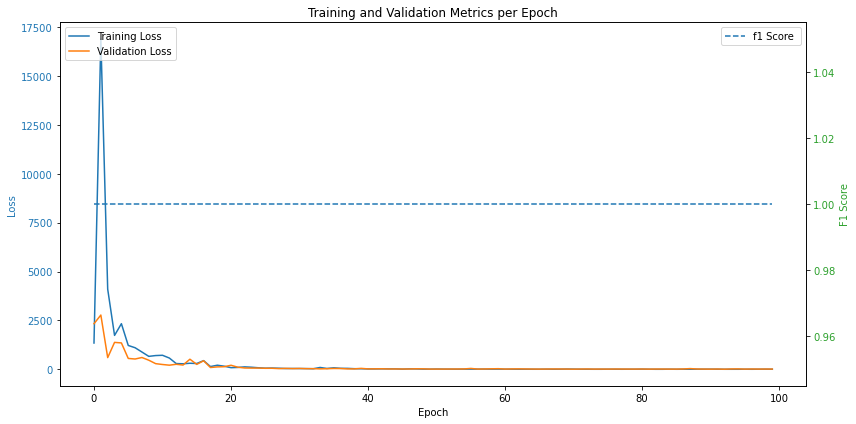

In [43]:
# define model parameters 

model_name ="_cuinet_rmn_14jan25_v1"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 100
save_interval = 10

# repertoire de sauvegarde 
# 14jan25: Deep-Chemometrics-main/data/dataset/Mango/Mango/models/_CuiNet_Mango
# save_path = os.path.dirname(local_path) + f'/models/{model_name}/' + model_name
save_path = local_path + '/data/rmn_196/' + f'/models/{model_name}/' + model_name
print(save_path)

# CuiNet est un modèle pré-défini 
model = CuiNet(spec_dims, mean = mean,std = std, out_dims=1) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')

print(model)
#CuiNet(
#  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
#  (fc1): Linear(in_features=614, out_features=36, bias=True)
#  (fc2): Linear(in_features=36, out_features=18, bias=True)
#  (fc3): Linear(in_features=18, out_features=12, bias=True)
#  (out): Linear(in_features=12, out_features=1, bias=True)
#)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification=True)

In [47]:

test(model,final_path,test_loader)

# => AssertionError: Torch not compiled with CUDA enabled


AssertionError: Torch not compiled with CUDA enabled

DeepSpectraCNN(
  (conv1): Conv1d(1, 8, kernel_size=(7,), stride=(3,), padding=(3,))
  (inception2): InceptionModule(
    (branch1): ConvBlock1D(
      (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
      (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (branch2): Sequential(
      (0): ConvBlock1D(
        (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
        (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): ConvBlock1D(
        (conv1d): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (branch3): Sequential(
      (0): ConvBlock1D(
        (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
        (batchnorm1d)

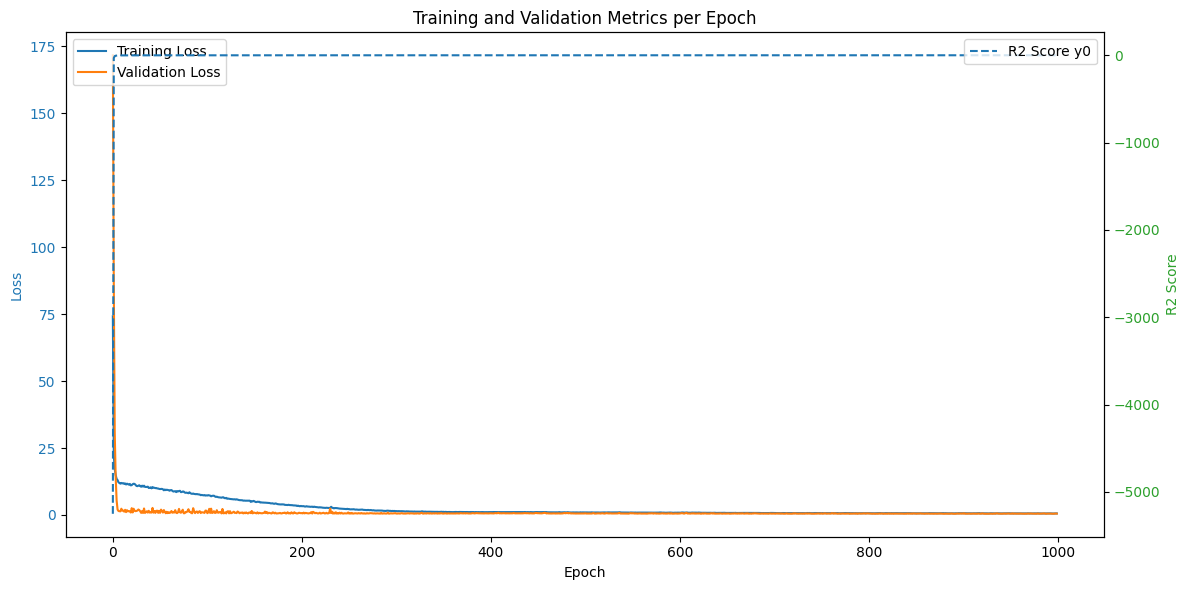

In [38]:
model_name ="_DeepSpectra_Mango_"  
LR = 0.01
num_epochs = 1000
save_interval = 10
data_path ="/home/metz/deepchemometrics/Aioly/data/dataset/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = DeepSpectraCNN(spec_dims, mean = mean,std = std, out_dims=1) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval)


CCC: 0.89528, R2: 0.73523, RMSEP: 1.12051


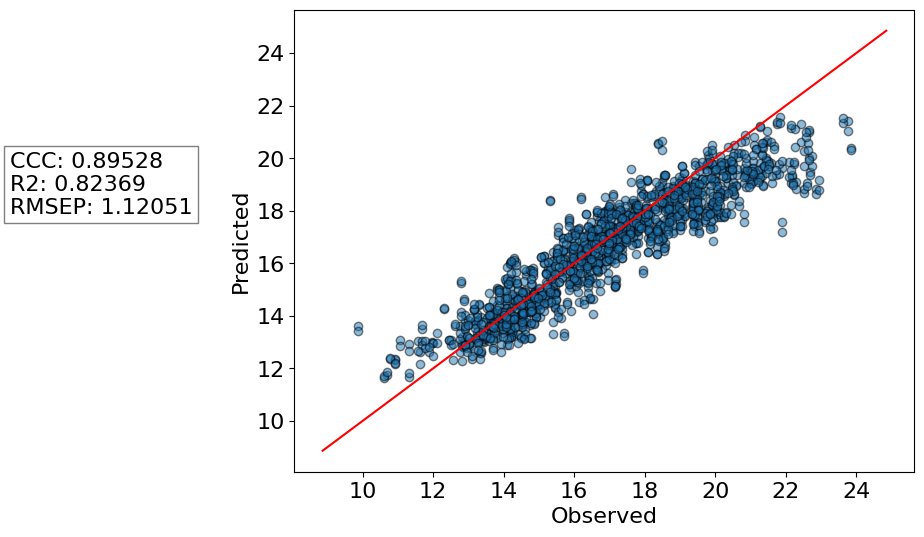

In [39]:
utils.test(model,final_path,test_loader)

ResNet1D(
  (conv1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, 

Epoch 35/1000 | Train Losses: y 0: 4.7487 | Validation Losses: y 0: 1.2309 | R2 Scores: y 0: 0.6647
Epoch 36/1000 | Train Losses: y 0: 4.6087 | Validation Losses: y 0: 5.9129 | R2 Scores: y 0: -0.3348
Epoch 37/1000 | Train Losses: y 0: 4.7763 | Validation Losses: y 0: 1.9644 | R2 Scores: y 0: 0.5658
Epoch 38/1000 | Train Losses: y 0: 4.5732 | Validation Losses: y 0: 1.0238 | R2 Scores: y 0: 0.7690
Epoch 39/1000 | Train Losses: y 0: 4.6190 | Validation Losses: y 0: 1.2720 | R2 Scores: y 0: 0.6902
Epoch 40/1000 | Train Losses: y 0: 4.6243 | Validation Losses: y 0: 1.5029 | R2 Scores: y 0: 0.6455
Model saved at epoch 40 to /Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometrics-main/data/dataset/Mango/Mango/models/_ResNET18_Mango_/_ResNET18_Mango__epoch_40.pth
Epoch 41/1000 | Train Losses: y 0: 4.5708 | Validation Losses: y 0: 0.9038 | R2 Scores: y 0: 0.7726
Epoch 42/1000 | Train Losses: y 0: 4.7762 | Validation Losses: y 0: 3.3616 | R2 Scores: y 0: 0.2107
Epoch 43/1000 | Train 

Epoch 105/1000 | Train Losses: y 0: 3.9955 | Validation Losses: y 0: 2.2452 | R2 Scores: y 0: 0.6221
Epoch 106/1000 | Train Losses: y 0: 4.0986 | Validation Losses: y 0: 1.7073 | R2 Scores: y 0: 0.6034
Epoch 107/1000 | Train Losses: y 0: 4.0487 | Validation Losses: y 0: 1.2077 | R2 Scores: y 0: 0.7190
Epoch 108/1000 | Train Losses: y 0: 4.0344 | Validation Losses: y 0: 1.3132 | R2 Scores: y 0: 0.7476
Epoch 109/1000 | Train Losses: y 0: 4.0823 | Validation Losses: y 0: 0.7804 | R2 Scores: y 0: 0.8242
Epoch 110/1000 | Train Losses: y 0: 3.9583 | Validation Losses: y 0: 1.5102 | R2 Scores: y 0: 0.7073
Model saved at epoch 110 to /Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometrics-main/data/dataset/Mango/Mango/models/_ResNET18_Mango_/_ResNET18_Mango__epoch_110.pth
Epoch 111/1000 | Train Losses: y 0: 4.1025 | Validation Losses: y 0: 0.7360 | R2 Scores: y 0: 0.8741
Epoch 112/1000 | Train Losses: y 0: 3.8991 | Validation Losses: y 0: 1.6531 | R2 Scores: y 0: 0.7027
Epoch 113/100

Epoch 174/1000 | Train Losses: y 0: 3.4326 | Validation Losses: y 0: 1.2806 | R2 Scores: y 0: 0.7860
Epoch 175/1000 | Train Losses: y 0: 3.3319 | Validation Losses: y 0: 0.7383 | R2 Scores: y 0: 0.8522
Epoch 176/1000 | Train Losses: y 0: 3.2951 | Validation Losses: y 0: 0.6883 | R2 Scores: y 0: 0.8594
Epoch 177/1000 | Train Losses: y 0: 3.4159 | Validation Losses: y 0: 0.8316 | R2 Scores: y 0: 0.8072
Epoch 178/1000 | Train Losses: y 0: 3.4650 | Validation Losses: y 0: 0.9725 | R2 Scores: y 0: 0.8101
Epoch 179/1000 | Train Losses: y 0: 3.3811 | Validation Losses: y 0: 0.6232 | R2 Scores: y 0: 0.8803
Epoch 180/1000 | Train Losses: y 0: 3.4139 | Validation Losses: y 0: 1.5056 | R2 Scores: y 0: 0.6861
Model saved at epoch 180 to /Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometrics-main/data/dataset/Mango/Mango/models/_ResNET18_Mango_/_ResNET18_Mango__epoch_180.pth
Epoch 181/1000 | Train Losses: y 0: 3.3118 | Validation Losses: y 0: 0.7400 | R2 Scores: y 0: 0.8459
Epoch 182/100

Epoch 243/1000 | Train Losses: y 0: 2.7539 | Validation Losses: y 0: 0.6404 | R2 Scores: y 0: 0.8770
Epoch 244/1000 | Train Losses: y 0: 2.7739 | Validation Losses: y 0: 0.9277 | R2 Scores: y 0: 0.7938
Epoch 245/1000 | Train Losses: y 0: 2.8116 | Validation Losses: y 0: 0.9875 | R2 Scores: y 0: 0.8097
Epoch 246/1000 | Train Losses: y 0: 2.7480 | Validation Losses: y 0: 0.5898 | R2 Scores: y 0: 0.8703
Epoch 247/1000 | Train Losses: y 0: 2.7905 | Validation Losses: y 0: 0.9459 | R2 Scores: y 0: 0.7147
Epoch 248/1000 | Train Losses: y 0: 2.7059 | Validation Losses: y 0: 0.9280 | R2 Scores: y 0: 0.7956
Epoch 249/1000 | Train Losses: y 0: 2.6990 | Validation Losses: y 0: 0.8223 | R2 Scores: y 0: 0.8186
Epoch 250/1000 | Train Losses: y 0: 2.7087 | Validation Losses: y 0: 0.8342 | R2 Scores: y 0: 0.7690
Model saved at epoch 250 to /Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometrics-main/data/dataset/Mango/Mango/models/_ResNET18_Mango_/_ResNET18_Mango__epoch_250.pth
Epoch 251/100

Epoch 312/1000 | Train Losses: y 0: 2.0613 | Validation Losses: y 0: 1.1910 | R2 Scores: y 0: 0.7155
Epoch 313/1000 | Train Losses: y 0: 2.1939 | Validation Losses: y 0: 1.0873 | R2 Scores: y 0: 0.7720
Epoch 314/1000 | Train Losses: y 0: 2.0733 | Validation Losses: y 0: 0.7837 | R2 Scores: y 0: 0.8733
Epoch 315/1000 | Train Losses: y 0: 2.1324 | Validation Losses: y 0: 0.6103 | R2 Scores: y 0: 0.8650
Epoch 316/1000 | Train Losses: y 0: 2.0638 | Validation Losses: y 0: 0.9273 | R2 Scores: y 0: 0.8232
Epoch 317/1000 | Train Losses: y 0: 2.0985 | Validation Losses: y 0: 1.0035 | R2 Scores: y 0: 0.8472
Epoch 318/1000 | Train Losses: y 0: 2.1442 | Validation Losses: y 0: 0.8875 | R2 Scores: y 0: 0.8268
Epoch 319/1000 | Train Losses: y 0: 2.1040 | Validation Losses: y 0: 0.5883 | R2 Scores: y 0: 0.8799
Epoch 320/1000 | Train Losses: y 0: 1.9774 | Validation Losses: y 0: 0.6409 | R2 Scores: y 0: 0.8730
Model saved at epoch 320 to /Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometri

Epoch 381/1000 | Train Losses: y 0: 1.5418 | Validation Losses: y 0: 1.0946 | R2 Scores: y 0: 0.7212
Epoch 382/1000 | Train Losses: y 0: 1.5331 | Validation Losses: y 0: 1.0794 | R2 Scores: y 0: 0.7809
Epoch 383/1000 | Train Losses: y 0: 1.5629 | Validation Losses: y 0: 0.6306 | R2 Scores: y 0: 0.8735
Epoch 384/1000 | Train Losses: y 0: 1.5588 | Validation Losses: y 0: 0.8459 | R2 Scores: y 0: 0.8489
Epoch 385/1000 | Train Losses: y 0: 1.5914 | Validation Losses: y 0: 0.8172 | R2 Scores: y 0: 0.8814
Epoch 386/1000 | Train Losses: y 0: 1.5459 | Validation Losses: y 0: 0.5849 | R2 Scores: y 0: 0.8879
Epoch 387/1000 | Train Losses: y 0: 1.5063 | Validation Losses: y 0: 0.6171 | R2 Scores: y 0: 0.8543
Epoch 388/1000 | Train Losses: y 0: 1.5091 | Validation Losses: y 0: 0.8605 | R2 Scores: y 0: 0.8126
Epoch 389/1000 | Train Losses: y 0: 1.4771 | Validation Losses: y 0: 1.0439 | R2 Scores: y 0: 0.7472
Epoch 390/1000 | Train Losses: y 0: 1.4856 | Validation Losses: y 0: 0.5998 | R2 Scores: y 

Epoch 451/1000 | Train Losses: y 0: 1.0889 | Validation Losses: y 0: 0.5236 | R2 Scores: y 0: 0.8937
Epoch 452/1000 | Train Losses: y 0: 1.1339 | Validation Losses: y 0: 0.6366 | R2 Scores: y 0: 0.8626
Epoch 453/1000 | Train Losses: y 0: 1.0280 | Validation Losses: y 0: 0.9624 | R2 Scores: y 0: 0.7882
Epoch 454/1000 | Train Losses: y 0: 1.0598 | Validation Losses: y 0: 0.5901 | R2 Scores: y 0: 0.8775
Epoch 455/1000 | Train Losses: y 0: 1.0971 | Validation Losses: y 0: 0.6757 | R2 Scores: y 0: 0.8456
Epoch 456/1000 | Train Losses: y 0: 1.0712 | Validation Losses: y 0: 0.6403 | R2 Scores: y 0: 0.8322
Epoch 457/1000 | Train Losses: y 0: 1.0007 | Validation Losses: y 0: 0.5941 | R2 Scores: y 0: 0.8583
Epoch 458/1000 | Train Losses: y 0: 1.0325 | Validation Losses: y 0: 0.6277 | R2 Scores: y 0: 0.8728
Epoch 459/1000 | Train Losses: y 0: 1.0145 | Validation Losses: y 0: 0.8428 | R2 Scores: y 0: 0.8171
Epoch 460/1000 | Train Losses: y 0: 1.0032 | Validation Losses: y 0: 0.6297 | R2 Scores: y 

Epoch 521/1000 | Train Losses: y 0: 0.7351 | Validation Losses: y 0: 0.4891 | R2 Scores: y 0: 0.9060
Epoch 522/1000 | Train Losses: y 0: 0.7225 | Validation Losses: y 0: 0.9468 | R2 Scores: y 0: 0.7670
Epoch 523/1000 | Train Losses: y 0: 0.7783 | Validation Losses: y 0: 0.7254 | R2 Scores: y 0: 0.8407
Epoch 524/1000 | Train Losses: y 0: 0.7360 | Validation Losses: y 0: 0.7694 | R2 Scores: y 0: 0.7986
Epoch 525/1000 | Train Losses: y 0: 0.7411 | Validation Losses: y 0: 0.5480 | R2 Scores: y 0: 0.8819
Epoch 526/1000 | Train Losses: y 0: 0.7269 | Validation Losses: y 0: 0.8293 | R2 Scores: y 0: 0.7581
Epoch 527/1000 | Train Losses: y 0: 0.7391 | Validation Losses: y 0: 0.5524 | R2 Scores: y 0: 0.9001
Epoch 528/1000 | Train Losses: y 0: 0.7382 | Validation Losses: y 0: 1.7324 | R2 Scores: y 0: 0.5832
Epoch 529/1000 | Train Losses: y 0: 0.7129 | Validation Losses: y 0: 1.2324 | R2 Scores: y 0: 0.7394
Epoch 530/1000 | Train Losses: y 0: 0.6923 | Validation Losses: y 0: 0.5861 | R2 Scores: y 

Epoch 591/1000 | Train Losses: y 0: 0.5591 | Validation Losses: y 0: 0.5385 | R2 Scores: y 0: 0.8886
Epoch 592/1000 | Train Losses: y 0: 0.5615 | Validation Losses: y 0: 0.6746 | R2 Scores: y 0: 0.8295
Epoch 593/1000 | Train Losses: y 0: 0.5828 | Validation Losses: y 0: 0.6362 | R2 Scores: y 0: 0.8398
Epoch 594/1000 | Train Losses: y 0: 0.6240 | Validation Losses: y 0: 0.9382 | R2 Scores: y 0: 0.7916
Epoch 595/1000 | Train Losses: y 0: 0.6184 | Validation Losses: y 0: 0.5857 | R2 Scores: y 0: 0.8826
Epoch 596/1000 | Train Losses: y 0: 0.6071 | Validation Losses: y 0: 0.7384 | R2 Scores: y 0: 0.8763
Epoch 597/1000 | Train Losses: y 0: 0.6053 | Validation Losses: y 0: 0.7782 | R2 Scores: y 0: 0.8058
Epoch 598/1000 | Train Losses: y 0: 0.6344 | Validation Losses: y 0: 0.5901 | R2 Scores: y 0: 0.8567
Epoch 599/1000 | Train Losses: y 0: 0.5975 | Validation Losses: y 0: 1.3557 | R2 Scores: y 0: 0.5956
Epoch 600/1000 | Train Losses: y 0: 0.5947 | Validation Losses: y 0: 0.7521 | R2 Scores: y 

Epoch 661/1000 | Train Losses: y 0: 0.5652 | Validation Losses: y 0: 0.6061 | R2 Scores: y 0: 0.8763
Epoch 662/1000 | Train Losses: y 0: 0.5553 | Validation Losses: y 0: 0.5138 | R2 Scores: y 0: 0.8929
Epoch 663/1000 | Train Losses: y 0: 0.5498 | Validation Losses: y 0: 0.8410 | R2 Scores: y 0: 0.8017
Epoch 664/1000 | Train Losses: y 0: 0.5596 | Validation Losses: y 0: 0.5869 | R2 Scores: y 0: 0.8771
Epoch 665/1000 | Train Losses: y 0: 0.5407 | Validation Losses: y 0: 0.5663 | R2 Scores: y 0: 0.8726
Epoch 666/1000 | Train Losses: y 0: 0.5445 | Validation Losses: y 0: 0.7086 | R2 Scores: y 0: 0.8283
Epoch 667/1000 | Train Losses: y 0: 0.5654 | Validation Losses: y 0: 0.5838 | R2 Scores: y 0: 0.8829
Epoch 668/1000 | Train Losses: y 0: 0.5451 | Validation Losses: y 0: 0.5686 | R2 Scores: y 0: 0.8847
Epoch 669/1000 | Train Losses: y 0: 0.5378 | Validation Losses: y 0: 0.7453 | R2 Scores: y 0: 0.8462
Epoch 670/1000 | Train Losses: y 0: 0.5407 | Validation Losses: y 0: 0.6502 | R2 Scores: y 

Epoch 731/1000 | Train Losses: y 0: 0.5863 | Validation Losses: y 0: 0.5789 | R2 Scores: y 0: 0.8918
Epoch 732/1000 | Train Losses: y 0: 0.5572 | Validation Losses: y 0: 0.5807 | R2 Scores: y 0: 0.8708
Epoch 733/1000 | Train Losses: y 0: 0.5612 | Validation Losses: y 0: 0.6128 | R2 Scores: y 0: 0.8722
Epoch 734/1000 | Train Losses: y 0: 0.5529 | Validation Losses: y 0: 0.5380 | R2 Scores: y 0: 0.8812
Epoch 735/1000 | Train Losses: y 0: 0.5616 | Validation Losses: y 0: 0.7337 | R2 Scores: y 0: 0.8269
Epoch 736/1000 | Train Losses: y 0: 0.5598 | Validation Losses: y 0: 0.6145 | R2 Scores: y 0: 0.8689
Epoch 737/1000 | Train Losses: y 0: 0.5636 | Validation Losses: y 0: 0.6228 | R2 Scores: y 0: 0.8608
Epoch 738/1000 | Train Losses: y 0: 0.5337 | Validation Losses: y 0: 0.5613 | R2 Scores: y 0: 0.8650
Epoch 739/1000 | Train Losses: y 0: 0.5430 | Validation Losses: y 0: 0.5136 | R2 Scores: y 0: 0.8984
Epoch 740/1000 | Train Losses: y 0: 0.5522 | Validation Losses: y 0: 0.5465 | R2 Scores: y 

Epoch 801/1000 | Train Losses: y 0: 0.5850 | Validation Losses: y 0: 0.6481 | R2 Scores: y 0: 0.8491
Epoch 802/1000 | Train Losses: y 0: 0.5706 | Validation Losses: y 0: 0.7757 | R2 Scores: y 0: 0.8365
Epoch 803/1000 | Train Losses: y 0: 0.6017 | Validation Losses: y 0: 0.6203 | R2 Scores: y 0: 0.8581
Epoch 804/1000 | Train Losses: y 0: 0.5831 | Validation Losses: y 0: 0.5709 | R2 Scores: y 0: 0.8785
Epoch 805/1000 | Train Losses: y 0: 0.5528 | Validation Losses: y 0: 0.5966 | R2 Scores: y 0: 0.8902
Epoch 806/1000 | Train Losses: y 0: 0.5524 | Validation Losses: y 0: 0.6770 | R2 Scores: y 0: 0.8336
Epoch 807/1000 | Train Losses: y 0: 0.5515 | Validation Losses: y 0: 0.9222 | R2 Scores: y 0: 0.7743
Epoch 808/1000 | Train Losses: y 0: 0.5703 | Validation Losses: y 0: 0.7700 | R2 Scores: y 0: 0.8218
Epoch 809/1000 | Train Losses: y 0: 0.5861 | Validation Losses: y 0: 0.7409 | R2 Scores: y 0: 0.8077
Epoch 810/1000 | Train Losses: y 0: 0.5680 | Validation Losses: y 0: 0.6433 | R2 Scores: y 

Epoch 871/1000 | Train Losses: y 0: 0.5484 | Validation Losses: y 0: 0.9471 | R2 Scores: y 0: 0.8099
Epoch 872/1000 | Train Losses: y 0: 0.5458 | Validation Losses: y 0: 1.0181 | R2 Scores: y 0: 0.7571
Epoch 873/1000 | Train Losses: y 0: 0.5524 | Validation Losses: y 0: 0.9519 | R2 Scores: y 0: 0.8534
Epoch 874/1000 | Train Losses: y 0: 0.5693 | Validation Losses: y 0: 0.5943 | R2 Scores: y 0: 0.8623
Epoch 875/1000 | Train Losses: y 0: 0.5525 | Validation Losses: y 0: 0.5535 | R2 Scores: y 0: 0.8830
Epoch 876/1000 | Train Losses: y 0: 0.5740 | Validation Losses: y 0: 0.5743 | R2 Scores: y 0: 0.8785
Epoch 877/1000 | Train Losses: y 0: 0.5547 | Validation Losses: y 0: 0.5640 | R2 Scores: y 0: 0.8814
Epoch 878/1000 | Train Losses: y 0: 0.5579 | Validation Losses: y 0: 1.2966 | R2 Scores: y 0: 0.6920
Epoch 879/1000 | Train Losses: y 0: 0.5806 | Validation Losses: y 0: 0.5139 | R2 Scores: y 0: 0.8908
Epoch 880/1000 | Train Losses: y 0: 0.5662 | Validation Losses: y 0: 0.6077 | R2 Scores: y 

Epoch 941/1000 | Train Losses: y 0: 0.5704 | Validation Losses: y 0: 0.5724 | R2 Scores: y 0: 0.8773
Epoch 942/1000 | Train Losses: y 0: 0.5777 | Validation Losses: y 0: 0.6690 | R2 Scores: y 0: 0.8421
Epoch 943/1000 | Train Losses: y 0: 0.5614 | Validation Losses: y 0: 0.7792 | R2 Scores: y 0: 0.8488
Epoch 944/1000 | Train Losses: y 0: 0.5833 | Validation Losses: y 0: 0.8263 | R2 Scores: y 0: 0.8304
Epoch 945/1000 | Train Losses: y 0: 0.5871 | Validation Losses: y 0: 0.5801 | R2 Scores: y 0: 0.8964
Epoch 946/1000 | Train Losses: y 0: 0.5593 | Validation Losses: y 0: 0.5208 | R2 Scores: y 0: 0.8982
Epoch 947/1000 | Train Losses: y 0: 0.5603 | Validation Losses: y 0: 0.5766 | R2 Scores: y 0: 0.8908
Epoch 948/1000 | Train Losses: y 0: 0.5755 | Validation Losses: y 0: 0.5475 | R2 Scores: y 0: 0.8825
Epoch 949/1000 | Train Losses: y 0: 0.5743 | Validation Losses: y 0: 0.6021 | R2 Scores: y 0: 0.8758
Epoch 950/1000 | Train Losses: y 0: 0.5665 | Validation Losses: y 0: 0.9062 | R2 Scores: y 

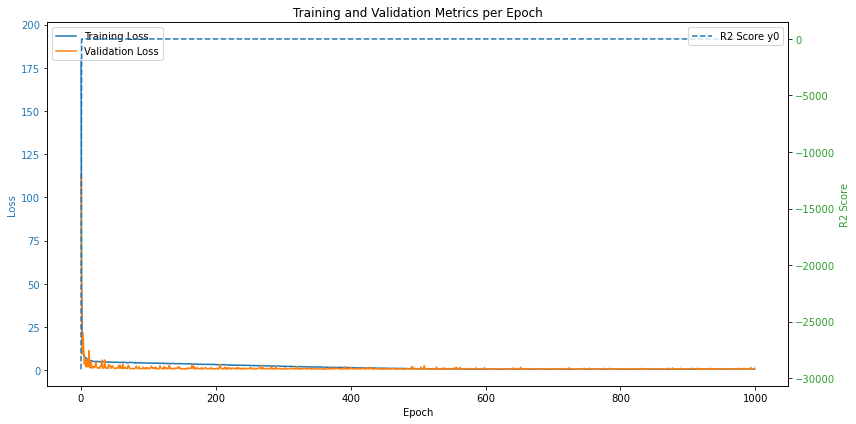

In [12]:

model_name ="_ResNET18_Mango_"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 1000
save_interval = 10
data_path ="/Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometrics-main/data/dataset/Mango/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = ResNet18_1D(mean = mean,std = std, out_dims=1) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')
print(model)

# lent à calculer! 
train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval)

CCC: 0.82269, R2: 0.45871, RMSEP: 1.40691


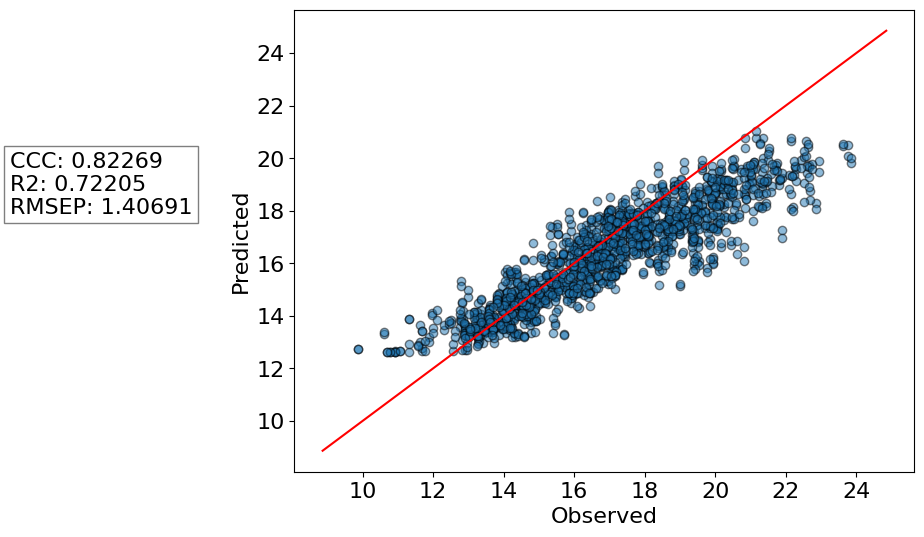

In [41]:
utils.test(model, final_path, test_loader)

In [13]:

model_name ="_ViT_1D_Mango_"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 1000
save_interval = 10
data_path ="/Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometrics-main/data/dataset/Mango/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = ViT_1D(mean = mean,std = std, seq_len = spec_dims, patch_size = 10, dim_embed = 64, trans_layers = 8, heads = 8, mlp_dim = 64, out_dims =1, dropout=0.5) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')
print(model)

# très lent!
train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval)

ViT_1D(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (n p) -> b n (p c)', p=10)
    (1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=10, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-7): 8 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.5, inplace=False)
          (to_qkv): Linear(in_features=64, out_features=1536, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=512, out_features=64, bias=True)
            (1): Dropout(p=0.5, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=64

KeyboardInterrupt: 

In [ ]:
utils.test(model, final_path, test_loader)

FullyConvNet(
  (conv1d_1): Conv1d(1, 2, kernel_size=(9,), stride=(1,))
  (avg_1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv1d_2): Conv1d(2, 2, kernel_size=(7,), stride=(1,))
  (avg_2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv1d_3): Conv1d(2, 4, kernel_size=(7,), stride=(1,))
  (avg_3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv1d_4): Conv1d(4, 8, kernel_size=(5,), stride=(1,))
  (avg_4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv1d_5): Conv1d(8, 12, kernel_size=(3,), stride=(1,))
  (dp): Dropout(p=0.5, inplace=False)
  (head): Conv1d(12, 1, kernel_size=(1,), stride=(1,))
)
Epoch 1/1000 | Train Losses: y 0: 262.1276 | Validation Losses: y 0: 264.8045 | R2 Scores: y 0: -1015894720.0000
Epoch 2/1000 | Train Losses: y 0: 260.8182 | Validation Losses: y 0: 263.6373 | R2 Scores: y 0: -552608896.0000
Epoch 3/1000 | Train Losses: y 0: 259.6909 | Validation Losses: y 0: 262.4601 | R2 Scores: y 0: -95945888.0000


Epoch 64/1000 | Train Losses: y 0: 6.5075 | Validation Losses: y 0: 5.1114 | R2 Scores: y 0: -8.9179
Epoch 65/1000 | Train Losses: y 0: 6.4550 | Validation Losses: y 0: 5.1003 | R2 Scores: y 0: -8.9590
Epoch 66/1000 | Train Losses: y 0: 6.3763 | Validation Losses: y 0: 5.1042 | R2 Scores: y 0: -8.9828
Epoch 67/1000 | Train Losses: y 0: 6.3534 | Validation Losses: y 0: 5.2734 | R2 Scores: y 0: -9.3159
Epoch 68/1000 | Train Losses: y 0: 6.4832 | Validation Losses: y 0: 5.1655 | R2 Scores: y 0: -9.0664
Epoch 69/1000 | Train Losses: y 0: 6.3509 | Validation Losses: y 0: 5.0888 | R2 Scores: y 0: -8.7710
Epoch 70/1000 | Train Losses: y 0: 6.3263 | Validation Losses: y 0: 5.0900 | R2 Scores: y 0: -8.7693
Model saved at epoch 70 to /Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometrics-main/data/dataset/Mango/Mango/models/_FullyConvNet_OSSL_/_FullyConvNet_OSSL__epoch_70.pth
Epoch 71/1000 | Train Losses: y 0: 6.3388 | Validation Losses: y 0: 5.1402 | R2 Scores: y 0: -8.9907
Epoch 72/

Epoch 133/1000 | Train Losses: y 0: 6.2416 | Validation Losses: y 0: 5.0710 | R2 Scores: y 0: -8.4872
Epoch 134/1000 | Train Losses: y 0: 6.1648 | Validation Losses: y 0: 5.1012 | R2 Scores: y 0: -8.5116
Epoch 135/1000 | Train Losses: y 0: 6.2685 | Validation Losses: y 0: 5.0977 | R2 Scores: y 0: -8.5309
Epoch 136/1000 | Train Losses: y 0: 6.2655 | Validation Losses: y 0: 5.1910 | R2 Scores: y 0: -8.8507
Epoch 137/1000 | Train Losses: y 0: 6.3416 | Validation Losses: y 0: 5.0770 | R2 Scores: y 0: -8.4643
Epoch 138/1000 | Train Losses: y 0: 6.2809 | Validation Losses: y 0: 5.0838 | R2 Scores: y 0: -8.4972
Epoch 139/1000 | Train Losses: y 0: 6.2654 | Validation Losses: y 0: 5.0678 | R2 Scores: y 0: -8.4350
Epoch 140/1000 | Train Losses: y 0: 6.2258 | Validation Losses: y 0: 5.0661 | R2 Scores: y 0: -8.5214
Model saved at epoch 140 to /Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometrics-main/data/dataset/Mango/Mango/models/_FullyConvNet_OSSL_/_FullyConvNet_OSSL__epoch_140.pth

Epoch 201/1000 | Train Losses: y 0: 6.1946 | Validation Losses: y 0: 5.0918 | R2 Scores: y 0: -8.0430
Epoch 202/1000 | Train Losses: y 0: 6.1469 | Validation Losses: y 0: 5.1400 | R2 Scores: y 0: -8.2453
Epoch 203/1000 | Train Losses: y 0: 6.0689 | Validation Losses: y 0: 5.1102 | R2 Scores: y 0: -8.1608
Epoch 204/1000 | Train Losses: y 0: 6.1891 | Validation Losses: y 0: 5.1198 | R2 Scores: y 0: -8.1358
Epoch 205/1000 | Train Losses: y 0: 6.2511 | Validation Losses: y 0: 5.0666 | R2 Scores: y 0: -7.9893
Epoch 206/1000 | Train Losses: y 0: 6.2824 | Validation Losses: y 0: 5.0595 | R2 Scores: y 0: -8.0392
Epoch 207/1000 | Train Losses: y 0: 6.1781 | Validation Losses: y 0: 5.0761 | R2 Scores: y 0: -8.1623
Epoch 208/1000 | Train Losses: y 0: 6.2841 | Validation Losses: y 0: 5.0421 | R2 Scores: y 0: -7.7954
Epoch 209/1000 | Train Losses: y 0: 6.2539 | Validation Losses: y 0: 5.0446 | R2 Scores: y 0: -7.6292
Epoch 210/1000 | Train Losses: y 0: 6.2223 | Validation Losses: y 0: 5.0694 | R2 S

Epoch 271/1000 | Train Losses: y 0: 6.2317 | Validation Losses: y 0: 5.1148 | R2 Scores: y 0: -8.2746
Epoch 272/1000 | Train Losses: y 0: 6.1732 | Validation Losses: y 0: 5.0371 | R2 Scores: y 0: -7.9589
Epoch 273/1000 | Train Losses: y 0: 6.2504 | Validation Losses: y 0: 5.0336 | R2 Scores: y 0: -7.9829
Epoch 274/1000 | Train Losses: y 0: 6.2276 | Validation Losses: y 0: 5.0264 | R2 Scores: y 0: -7.9179
Epoch 275/1000 | Train Losses: y 0: 6.1926 | Validation Losses: y 0: 5.0233 | R2 Scores: y 0: -7.8882
Epoch 276/1000 | Train Losses: y 0: 6.2030 | Validation Losses: y 0: 5.0385 | R2 Scores: y 0: -8.0696
Epoch 277/1000 | Train Losses: y 0: 6.2790 | Validation Losses: y 0: 5.0501 | R2 Scores: y 0: -7.9572
Epoch 278/1000 | Train Losses: y 0: 6.1679 | Validation Losses: y 0: 5.0603 | R2 Scores: y 0: -8.0370
Epoch 279/1000 | Train Losses: y 0: 6.1803 | Validation Losses: y 0: 5.0224 | R2 Scores: y 0: -7.9401
Epoch 280/1000 | Train Losses: y 0: 6.1904 | Validation Losses: y 0: 5.0253 | R2 S

Epoch 341/1000 | Train Losses: y 0: 6.0346 | Validation Losses: y 0: 5.0710 | R2 Scores: y 0: -7.1976
Epoch 342/1000 | Train Losses: y 0: 6.0739 | Validation Losses: y 0: 5.0824 | R2 Scores: y 0: -7.2969
Epoch 343/1000 | Train Losses: y 0: 5.9539 | Validation Losses: y 0: 5.0221 | R2 Scores: y 0: -7.3311
Epoch 344/1000 | Train Losses: y 0: 6.0609 | Validation Losses: y 0: 5.0495 | R2 Scores: y 0: -7.7505
Epoch 345/1000 | Train Losses: y 0: 5.9626 | Validation Losses: y 0: 5.0095 | R2 Scores: y 0: -7.6161
Epoch 346/1000 | Train Losses: y 0: 5.9641 | Validation Losses: y 0: 4.9999 | R2 Scores: y 0: -7.6616
Epoch 347/1000 | Train Losses: y 0: 6.0309 | Validation Losses: y 0: 5.0063 | R2 Scores: y 0: -7.5343
Epoch 348/1000 | Train Losses: y 0: 6.0402 | Validation Losses: y 0: 5.0131 | R2 Scores: y 0: -7.4039
Epoch 349/1000 | Train Losses: y 0: 5.9947 | Validation Losses: y 0: 5.0319 | R2 Scores: y 0: -7.4924
Epoch 350/1000 | Train Losses: y 0: 6.0610 | Validation Losses: y 0: 5.0471 | R2 S

Epoch 411/1000 | Train Losses: y 0: 6.0073 | Validation Losses: y 0: 4.9621 | R2 Scores: y 0: -6.5537
Epoch 412/1000 | Train Losses: y 0: 6.0217 | Validation Losses: y 0: 5.0028 | R2 Scores: y 0: -7.0326
Epoch 413/1000 | Train Losses: y 0: 5.9883 | Validation Losses: y 0: 4.9905 | R2 Scores: y 0: -7.2243
Epoch 414/1000 | Train Losses: y 0: 6.0091 | Validation Losses: y 0: 4.9739 | R2 Scores: y 0: -6.8648
Epoch 415/1000 | Train Losses: y 0: 5.9322 | Validation Losses: y 0: 4.9453 | R2 Scores: y 0: -6.8545
Epoch 416/1000 | Train Losses: y 0: 5.9264 | Validation Losses: y 0: 5.0438 | R2 Scores: y 0: -7.2305
Epoch 417/1000 | Train Losses: y 0: 5.9215 | Validation Losses: y 0: 4.9714 | R2 Scores: y 0: -7.0387
Epoch 418/1000 | Train Losses: y 0: 5.9990 | Validation Losses: y 0: 4.9649 | R2 Scores: y 0: -7.0690
Epoch 419/1000 | Train Losses: y 0: 5.9058 | Validation Losses: y 0: 4.9965 | R2 Scores: y 0: -7.2438
Epoch 420/1000 | Train Losses: y 0: 5.8894 | Validation Losses: y 0: 5.0499 | R2 S

Epoch 481/1000 | Train Losses: y 0: 5.9309 | Validation Losses: y 0: 4.9200 | R2 Scores: y 0: -5.8917
Epoch 482/1000 | Train Losses: y 0: 5.8688 | Validation Losses: y 0: 4.8804 | R2 Scores: y 0: -5.8119
Epoch 483/1000 | Train Losses: y 0: 5.9612 | Validation Losses: y 0: 4.8424 | R2 Scores: y 0: -5.6417
Epoch 484/1000 | Train Losses: y 0: 5.8181 | Validation Losses: y 0: 4.8372 | R2 Scores: y 0: -5.5417
Epoch 485/1000 | Train Losses: y 0: 5.9947 | Validation Losses: y 0: 4.8402 | R2 Scores: y 0: -5.5645
Epoch 486/1000 | Train Losses: y 0: 5.9757 | Validation Losses: y 0: 4.8558 | R2 Scores: y 0: -5.6353
Epoch 487/1000 | Train Losses: y 0: 5.9220 | Validation Losses: y 0: 4.8627 | R2 Scores: y 0: -5.6830
Epoch 488/1000 | Train Losses: y 0: 5.8836 | Validation Losses: y 0: 4.9397 | R2 Scores: y 0: -5.7349
Epoch 489/1000 | Train Losses: y 0: 5.8621 | Validation Losses: y 0: 4.9209 | R2 Scores: y 0: -5.6070
Epoch 490/1000 | Train Losses: y 0: 5.8710 | Validation Losses: y 0: 4.8644 | R2 S

Epoch 551/1000 | Train Losses: y 0: 5.7132 | Validation Losses: y 0: 4.7227 | R2 Scores: y 0: -4.7441
Epoch 552/1000 | Train Losses: y 0: 5.7170 | Validation Losses: y 0: 4.7599 | R2 Scores: y 0: -4.9597
Epoch 553/1000 | Train Losses: y 0: 5.7248 | Validation Losses: y 0: 4.7242 | R2 Scores: y 0: -4.9411
Epoch 554/1000 | Train Losses: y 0: 5.7233 | Validation Losses: y 0: 4.7506 | R2 Scores: y 0: -4.8843
Epoch 555/1000 | Train Losses: y 0: 5.7103 | Validation Losses: y 0: 4.7183 | R2 Scores: y 0: -4.7295
Epoch 556/1000 | Train Losses: y 0: 5.7932 | Validation Losses: y 0: 4.7165 | R2 Scores: y 0: -4.6252
Epoch 557/1000 | Train Losses: y 0: 5.7414 | Validation Losses: y 0: 4.7148 | R2 Scores: y 0: -4.6685
Epoch 558/1000 | Train Losses: y 0: 5.7451 | Validation Losses: y 0: 4.7611 | R2 Scores: y 0: -4.9414
Epoch 559/1000 | Train Losses: y 0: 5.7195 | Validation Losses: y 0: 4.8693 | R2 Scores: y 0: -5.1602
Epoch 560/1000 | Train Losses: y 0: 5.7707 | Validation Losses: y 0: 4.7724 | R2 S

Epoch 621/1000 | Train Losses: y 0: 5.6181 | Validation Losses: y 0: 4.7036 | R2 Scores: y 0: -4.8982
Epoch 622/1000 | Train Losses: y 0: 5.7335 | Validation Losses: y 0: 4.7064 | R2 Scores: y 0: -4.9314
Epoch 623/1000 | Train Losses: y 0: 5.7219 | Validation Losses: y 0: 4.6901 | R2 Scores: y 0: -4.8079
Epoch 624/1000 | Train Losses: y 0: 5.6833 | Validation Losses: y 0: 4.7081 | R2 Scores: y 0: -4.8332
Epoch 625/1000 | Train Losses: y 0: 5.7191 | Validation Losses: y 0: 4.7869 | R2 Scores: y 0: -4.9956
Epoch 626/1000 | Train Losses: y 0: 5.7285 | Validation Losses: y 0: 4.8150 | R2 Scores: y 0: -5.1185
Epoch 627/1000 | Train Losses: y 0: 5.6874 | Validation Losses: y 0: 4.6906 | R2 Scores: y 0: -4.8885
Epoch 628/1000 | Train Losses: y 0: 5.7554 | Validation Losses: y 0: 4.6745 | R2 Scores: y 0: -4.7840
Epoch 629/1000 | Train Losses: y 0: 5.7150 | Validation Losses: y 0: 4.6840 | R2 Scores: y 0: -4.8766
Epoch 630/1000 | Train Losses: y 0: 5.7373 | Validation Losses: y 0: 4.6834 | R2 S

Epoch 691/1000 | Train Losses: y 0: 5.6749 | Validation Losses: y 0: 4.6646 | R2 Scores: y 0: -4.6245
Epoch 692/1000 | Train Losses: y 0: 5.6244 | Validation Losses: y 0: 4.6788 | R2 Scores: y 0: -4.7101
Epoch 693/1000 | Train Losses: y 0: 5.6348 | Validation Losses: y 0: 4.6582 | R2 Scores: y 0: -4.7288
Epoch 694/1000 | Train Losses: y 0: 5.6120 | Validation Losses: y 0: 4.6849 | R2 Scores: y 0: -4.8154
Epoch 695/1000 | Train Losses: y 0: 5.5986 | Validation Losses: y 0: 4.6937 | R2 Scores: y 0: -4.7555
Epoch 696/1000 | Train Losses: y 0: 5.7444 | Validation Losses: y 0: 4.6626 | R2 Scores: y 0: -4.5258
Epoch 697/1000 | Train Losses: y 0: 5.7088 | Validation Losses: y 0: 4.7221 | R2 Scores: y 0: -4.6814
Epoch 698/1000 | Train Losses: y 0: 5.7067 | Validation Losses: y 0: 4.7537 | R2 Scores: y 0: -4.7467
Epoch 699/1000 | Train Losses: y 0: 5.8000 | Validation Losses: y 0: 4.6780 | R2 Scores: y 0: -4.6122
Epoch 700/1000 | Train Losses: y 0: 5.5888 | Validation Losses: y 0: 4.6567 | R2 S

Epoch 761/1000 | Train Losses: y 0: 5.6066 | Validation Losses: y 0: 4.6335 | R2 Scores: y 0: -4.5581
Epoch 762/1000 | Train Losses: y 0: 5.6328 | Validation Losses: y 0: 4.6291 | R2 Scores: y 0: -4.5650
Epoch 763/1000 | Train Losses: y 0: 5.6612 | Validation Losses: y 0: 4.6364 | R2 Scores: y 0: -4.6154
Epoch 764/1000 | Train Losses: y 0: 5.6511 | Validation Losses: y 0: 4.6482 | R2 Scores: y 0: -4.6897
Epoch 765/1000 | Train Losses: y 0: 5.5458 | Validation Losses: y 0: 4.6372 | R2 Scores: y 0: -4.7055
Epoch 766/1000 | Train Losses: y 0: 5.6188 | Validation Losses: y 0: 4.6798 | R2 Scores: y 0: -4.7157
Epoch 767/1000 | Train Losses: y 0: 5.7056 | Validation Losses: y 0: 4.6606 | R2 Scores: y 0: -4.7119
Epoch 768/1000 | Train Losses: y 0: 5.6194 | Validation Losses: y 0: 4.6495 | R2 Scores: y 0: -4.7328
Epoch 769/1000 | Train Losses: y 0: 5.6290 | Validation Losses: y 0: 4.6403 | R2 Scores: y 0: -4.6236
Epoch 770/1000 | Train Losses: y 0: 5.6284 | Validation Losses: y 0: 4.6260 | R2 S

Epoch 831/1000 | Train Losses: y 0: 5.5914 | Validation Losses: y 0: 4.5731 | R2 Scores: y 0: -4.6523
Epoch 832/1000 | Train Losses: y 0: 5.5100 | Validation Losses: y 0: 4.5382 | R2 Scores: y 0: -4.5058
Epoch 833/1000 | Train Losses: y 0: 5.4825 | Validation Losses: y 0: 4.5371 | R2 Scores: y 0: -4.5021
Epoch 834/1000 | Train Losses: y 0: 5.5722 | Validation Losses: y 0: 4.5698 | R2 Scores: y 0: -4.6713
Epoch 835/1000 | Train Losses: y 0: 5.4620 | Validation Losses: y 0: 4.5238 | R2 Scores: y 0: -4.5425
Epoch 836/1000 | Train Losses: y 0: 5.4423 | Validation Losses: y 0: 4.5166 | R2 Scores: y 0: -4.4357
Epoch 837/1000 | Train Losses: y 0: 5.5208 | Validation Losses: y 0: 4.5273 | R2 Scores: y 0: -4.5347
Epoch 838/1000 | Train Losses: y 0: 5.5146 | Validation Losses: y 0: 4.5097 | R2 Scores: y 0: -4.3123
Epoch 839/1000 | Train Losses: y 0: 5.5320 | Validation Losses: y 0: 4.5080 | R2 Scores: y 0: -4.3050
Epoch 840/1000 | Train Losses: y 0: 5.4431 | Validation Losses: y 0: 4.5876 | R2 S

Epoch 901/1000 | Train Losses: y 0: 5.3736 | Validation Losses: y 0: 4.3268 | R2 Scores: y 0: -3.3936
Epoch 902/1000 | Train Losses: y 0: 5.3040 | Validation Losses: y 0: 4.3226 | R2 Scores: y 0: -3.3524
Epoch 903/1000 | Train Losses: y 0: 5.3522 | Validation Losses: y 0: 4.3205 | R2 Scores: y 0: -3.3406
Epoch 904/1000 | Train Losses: y 0: 5.2549 | Validation Losses: y 0: 4.3234 | R2 Scores: y 0: -3.3720
Epoch 905/1000 | Train Losses: y 0: 5.3260 | Validation Losses: y 0: 4.3207 | R2 Scores: y 0: -3.3732
Epoch 906/1000 | Train Losses: y 0: 5.3518 | Validation Losses: y 0: 4.3263 | R2 Scores: y 0: -3.3994
Epoch 907/1000 | Train Losses: y 0: 5.2715 | Validation Losses: y 0: 4.3264 | R2 Scores: y 0: -3.2932
Epoch 908/1000 | Train Losses: y 0: 5.3139 | Validation Losses: y 0: 4.3132 | R2 Scores: y 0: -3.1820
Epoch 909/1000 | Train Losses: y 0: 5.3189 | Validation Losses: y 0: 4.3558 | R2 Scores: y 0: -3.1513
Epoch 910/1000 | Train Losses: y 0: 5.4164 | Validation Losses: y 0: 4.4459 | R2 S

Epoch 971/1000 | Train Losses: y 0: 5.2680 | Validation Losses: y 0: 4.2306 | R2 Scores: y 0: -2.7512
Epoch 972/1000 | Train Losses: y 0: 5.1599 | Validation Losses: y 0: 4.2371 | R2 Scores: y 0: -2.7715
Epoch 973/1000 | Train Losses: y 0: 5.2804 | Validation Losses: y 0: 4.2478 | R2 Scores: y 0: -2.7821
Epoch 974/1000 | Train Losses: y 0: 5.1932 | Validation Losses: y 0: 4.2584 | R2 Scores: y 0: -2.7554
Epoch 975/1000 | Train Losses: y 0: 5.2424 | Validation Losses: y 0: 4.3526 | R2 Scores: y 0: -2.8813
Epoch 976/1000 | Train Losses: y 0: 5.2067 | Validation Losses: y 0: 4.2463 | R2 Scores: y 0: -2.7726
Epoch 977/1000 | Train Losses: y 0: 5.2330 | Validation Losses: y 0: 4.2673 | R2 Scores: y 0: -2.8541
Epoch 978/1000 | Train Losses: y 0: 5.1575 | Validation Losses: y 0: 4.2186 | R2 Scores: y 0: -2.7100
Epoch 979/1000 | Train Losses: y 0: 5.1901 | Validation Losses: y 0: 4.2413 | R2 Scores: y 0: -2.7055
Epoch 980/1000 | Train Losses: y 0: 5.1689 | Validation Losses: y 0: 4.2185 | R2 S

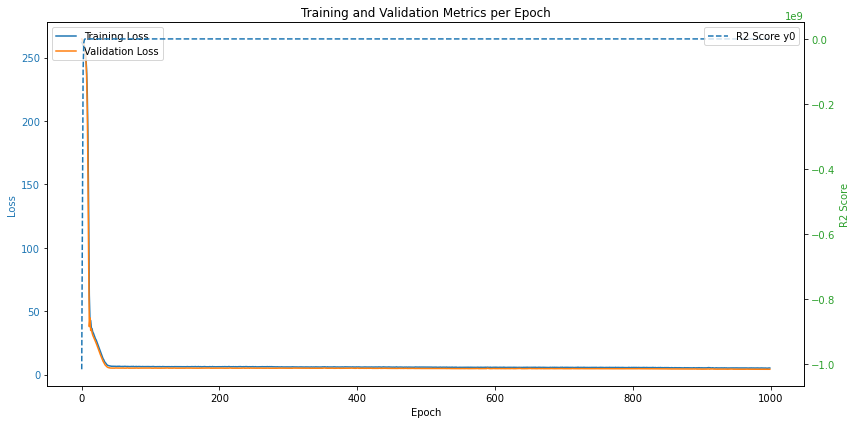

In [15]:
model_name ="_FullyConvNet_OSSL_"
spec_dims = x_cal.shape[1]
LR = 0.001
num_epochs = 1000
save_interval = 10
data_path ="/Users/jean-claudeboulet/Desktop/florent_maxime/Deep-Chemometrics-main/data/dataset/Mango/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = FullyConvNet(spec_dims, mean = mean,std = std,out_dims=1)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval)
# rapide! 

In [21]:
utils.test(model, final_path, test_loader)

NameError: name 'utils' is not defined

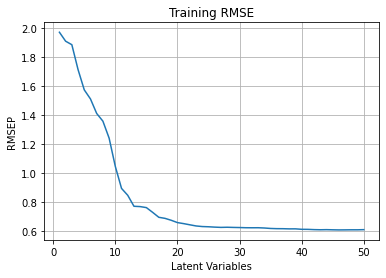

In [18]:
# PLS model test 
ncomp=50
pls =PLS(ncomp=ncomp)
pls.fit(x_cal, y_cal)

perf = []
for lv in range(ncomp):
    y_pred = pls.predict(x_val, lv)
    rmse = torch.sqrt(F.mse_loss(y_pred, torch.Tensor(y_val), reduction='none')).mean(dim=0)
    perf.append(rmse)
    
fig=plt.figure()
plt.plot(range(1, ncomp + 1), [p.item() for p in perf] )
plt.xlabel('Latent Variables')
plt.ylabel('RMSEP')
plt.title(f'Training RMSE')
plt.grid(True)
plt.show()

CCC: 0.91316, R2: 0.79941, RMSEP: 1.04670


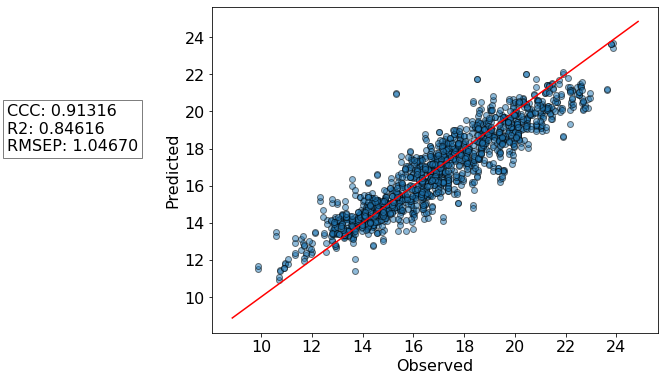

In [19]:
y_pred = pls.predict(Xtest, 20)
rmse = torch.sqrt(F.mse_loss(y_pred, torch.Tensor(Ytest), reduction='none')).mean(dim=0)
y_pred = np.array(y_pred)
print("CCC: %5.5f, R2: %5.5f, RMSEP: %5.5f"%(ccc(y_pred,Ytest), r2_score(y_pred, Ytest), RMSEP(y_pred, Ytest)))

plt.figure(figsize=(8,6))

# Scatter plot of X vs Y
plt.scatter(Ytest,y_pred,edgecolors='k',alpha=0.5)

# Plot of the 45 degree line
plt.plot([Ytest.min()-1,Ytest.max()+1],[Ytest.min()-1,Ytest.max()+1],'r')
  
plt.text(0, 0.75*Ytest.max(), "CCC: %5.5f"%(ccc(Ytest,y_pred))+"\nR2: %5.5f"%(r2_score(Ytest,y_pred))+"\nRMSEP: %5.5f"%(RMSEP(Ytest,y_pred)),
         fontsize=16, bbox=dict(facecolor='white', alpha=0.5))


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Observed',fontsize=16)
plt.ylabel('Predicted',fontsize=16)

plt.show(block=False)
